In [1]:
import os
import gc
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
from glob import glob
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

In [3]:
ROOT = Path("/kaggle/input/home-credit-credit-risk-model-stability")
TRAIN_DIR = ROOT / "parquet_files" / "train"
TEST_DIR = ROOT / "parquet_files" / "test"


MODEL_PATH = "/kaggle/working/homecredit-dataset/best_model.pth"
LOAD_MODEL = False

# Pipline

In [4]:
class Pipeline:
    @staticmethod
    def set_data_type(data_frame):
        for col in data_frame.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                data_frame = data_frame.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                data_frame = data_frame.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P","A"):
                data_frame = data_frame.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("D"):
                data_frame = data_frame.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("M"):
                data_frame = data_frame.with_columns(pl.col(col).cast(pl.String))
        
        return data_frame
    
    @staticmethod
    def handle_dates(data_frame):
        for col in data_frame.columns:
            if col[-1] in ("D"):
                data_frame = data_frame.with_columns(pl.col(col)-pl.col("date_decision"))
                data_frame = data_frame.with_columns(pl.col(col).dt.total_days())
                
        data_frame = data_frame.drop("date_decision", "MONTH")
        
        return data_frame
    
    @staticmethod
    def filter_cols(data_frame):
        for col in data_frame.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = data_frame[col].is_null().mean()
                
                if isnull > 0.95:
                    data_frame = data_frame.drop(col)
            
        for col in data_frame.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (data_frame[col].dtype == pl.String):
                frq = data_frame[col].n_unique()
                if (frq == 1) | (frq > 200):
                    data_frame = data_frame.drop(col)
            
        return data_frame
            
                

# Automatic Aggregation

In [5]:
class Aggregator:
    @staticmethod
    def num_expr(data_frame):
        cols = [col for col in data_frame.columns if col[-1] in ['A','P']]
        expr_mim = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        
        return expr_mim, expr_max
    
    @staticmethod
    def date_expr(data_frame):
        
        cols = [col for col in data_frame.columns if col[-1] in ("D",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]

        return expr_max, expr_min
    
    @staticmethod
    def str_expr(data_frame):
        
        cols = [col for col in data_frame.columns if col[-1] in ("M",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]

        return expr_max, expr_min
    
    @staticmethod
    def other_expr(data_frame):
        
        cols = [col for col in data_frame.columns if col[-1] in ("T", "L")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]

        return expr_max, expr_min
    
    @staticmethod
    def count_expr(data_frame): 
        
        cols = [col for col in data_frame.columns if "num_group" in col]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]

        return expr_max, expr_min
    
    @staticmethod
    def get_exprs(df):
        maxexprs = Aggregator.num_expr(df)[0] + \
                Aggregator.date_expr(df)[0] + \
                Aggregator.str_expr(df)[0] + \
                Aggregator.other_expr(df)[0] + \
                Aggregator.count_expr(df)[0]
        
        minexprs = Aggregator.num_expr(df)[1] + \
                Aggregator.date_expr(df)[1] + \
                Aggregator.str_expr(df)[1] + \
                Aggregator.other_expr(df)[1] + \
                Aggregator.count_expr(df)[1]
        
        return maxexprs, minexprs

# File I/O

In [6]:
def read_file(path, depth=None): 
    data_frame = pl.read_parquet(path)
    data_frame = data_frame.pipe(Pipeline.set_data_type)
    
    if depth in [1, 2]:
        maxexprs, minexprs = Aggregator.get_exprs(data_frame)
        data_frame = data_frame.group_by("case_id").agg(*maxexprs, *minexprs)
    
    return data_frame

def read_files(regex_path, depth=None):
    chunks = []
    for path in glob(str(regex_path)):
        chunks.append(pl.read_parquet(path).pipe(Pipeline.set_data_type))
        
    data_frame = pl.concat(chunks, how="vertical_relaxed")
    if depth in [1, 2]:
        maxexprs, minexprs = Aggregator.get_exprs(data_frame)
        data_frame = data_frame.group_by("case_id").agg(*maxexprs, *minexprs)
    
    return data_frame

## Feature Engineering

In [7]:
def feature_eng(data_frame_base, depth_0 ,depth_1, depth_2):
    data_frame_base = (
        data_frame_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
    
    for i, data_frame in enumerate(depth_0 + depth_1 + depth_2):
        data_frame_base = data_frame_base.join(data_frame, how="left", on="case_id", suffix=f"_{i}")
        
    data_frame_base = data_frame_base.pipe(Pipeline.handle_dates)
    
    return data_frame_base

In [8]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    return df_data, cat_cols

In [9]:
data_store = {
    "data_frame_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
    ]
}

In [10]:
df_train = feature_eng(**data_store)

print("train data shape:\t", df_train.shape)

train data shape:	 (1526659, 528)


In [11]:
data_store = {
    "data_frame_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
    ]
}

In [12]:
df_test = feature_eng(**data_store)

print("test data shape:\t", df_test.shape)

test data shape:	 (10, 527)


In [13]:
df_train.describe()

describe,case_id,WEEK_NUM,target,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,assignmentdate_4955616D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,dateofbirth_342D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,for3years_128L,for3years_504L,for3years_584L,formonth_118L,formonth_206L,formonth_535L,forquarter_1017L,forquarter_462L,forquarter_634L,fortoday_1092L,forweek_1077L,forweek_528L,forweek_601L,foryear_618L,foryear_818L,…,min_relationshiptoclient_415T,min_relationshiptoclient_642T,min_remitter_829L,min_role_1084L,min_role_993L,min_safeguarantyflag_411L,min_sex_738L,min_type_25L,min_num_group1_8,min_amount_416A,max_contractenddate_991D,max_openingdate_313D,max_num_group1_9,max_amount_416A,min_contractenddate_991D,min_openingdate_313D,min_num_group1_9,min_last180dayaveragebalance_704A,min_last180dayturnover_1134A,min_last30dayturnover_651A,max_openingdate_857D,max_num_group1_10,max_last180dayaveragebalance_704A,max_last180dayturnover_1134A,max_last30dayturnover_651A,min_openingdate_857D,min_num_group1_10,min_pmts_dpdvalue_108P,min_pmts_pmtsoverdue_635A,max_pmts_date_1107D,max_num_group1_11,max_num_group2,max_pmts_dpdvalue_108P,max_pmts_pmtsoverdue_635A,min_pmts_date_1107D,min_num_group1_11,min_num_group2
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,str,str,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1.526659e6,1.526659e6,1.526659e6,1.526659e6,1.526659e6,136996.0,114978.0,71633.0,607871.0,157329.0,1.385691e6,36500.0,1.385691e6,1.385691e6,1.385691e6,1.385691e6,1.385691e6,"""1500476""","""1500476""","""1500476""",1.385691e6,36514.0,36514.0,36514.0,36514.0,36514.0,36514.0,36514.0,36514.0,36514.0,36514.0,36514.0,36514.0,36514.0,36514.0,36514.0,…,"""591033""","""591033""","""591033""","""1526659""","""12458""","""1526657""","""1526659""","""1526659""",1.526659e6,105111.0,59619.0,105111.0,105111.0,105111.0,59619.0,105111.0,105111.0,11289.0,10272.0,10272.0,105087.0,111772.0,11289.0,10272.0,10272.0,105087.0,111772.0,36415.0,36415.0,36447.0,36447.0,36447.0,36415.0,36415.0,36447.0,36447.0,36447.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,1.389663e6,1.411681e6,1.455026e6,918788.0,1.36933e6,140968.0,1.490159e6,140968.0,140968.0,140968.0,140968.0,140968.0,"""26183""","""26183""","""26183""",140968.0,1.490145e6,1.490145e6,1.490145e6,1.490145e6,1.490145e6,1.490145e6,1.490145e6,1.490145e6,1.490145e6,1.490145e6,1.490145e6,1.490145e6,1.490145e6,1.490145e6,1.490145e6,…,"""935626""","""935626""","""935626""","""0""","""1514201""","""2""","""0""","""0""",0.0,1.421548e6,1.46704e6,1.421548e6,1.421548e6,1.421548e6,1.46704e6,1.421548e6,1.421548e6,1.51537e6,1.516387e6,1.516387e6,1.421572e6,1.414887e6,1.51537e6,1.516387e6,1.516387e6,1.421572e6,1.414887e6,1.490244e6,1.490244e6,1.490212e6,1.490212e6,1.490212e6,1.490244e6,1.490244e6,1.490212e6,1.490212e6,1.490212e6
"""mean""",1.2861e6,40.769036,0.031437,6.425584,3.984014,-2368.489496,13.945155,-2837.152974,-16065.771127,641604.417651,-16282.376476,-15427.647562,1.607715,2.388656,0.517708,4.777066,1.21142,null,null,null,2.86059,0.000082,4.382346,0.007696,0.0,0.000356,0.236759,0.000959,0.0,0.613929,0.036945,0.000055,0.09013,0.0,0.000055,0.002081,…,null,null,null,null,null,null,null,null,0.0,5961.107354,-616.17793,-1537.268421,0.380312,11053.429841,-638.582851,-1656.916907,0.0,105.089419,38249.815879,4842.416497,-1541.16728,0.407347,118.227329,40340.876365,5345.528562,-1660.075309,0.0,4514.094906,3.234041,-11.851181,1.246961,22.241419,63313.634217,36.426704,-692.897111,0.000055,0.0
"""std""",718946.592285,23.797981,0.174496,3.512803,1.98848,2316.350761,0.410493,1962.589538,5108.123925,980327.297131,5054.532403,4824.322847,2.083003,2.891115,0.899238,5.168856,1.655931,null,null,null,

In [14]:
df_train.null_count()

case_id,WEEK_NUM,target,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,assignmentdate_4955616D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,dateofbirth_342D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,for3years_128L,for3years_504L,for3years_584L,formonth_118L,formonth_206L,formonth_535L,forquarter_1017L,forquarter_462L,forquarter_634L,fortoday_1092L,forweek_1077L,forweek_528L,forweek_601L,foryear_618L,foryear_818L,foryear_850L,…,min_relationshiptoclient_415T,min_relationshiptoclient_642T,min_remitter_829L,min_role_1084L,min_role_993L,min_safeguarantyflag_411L,min_sex_738L,min_type_25L,min_num_group1_8,min_amount_416A,max_contractenddate_991D,max_openingdate_313D,max_num_group1_9,max_amount_416A,min_contractenddate_991D,min_openingdate_313D,min_num_group1_9,min_last180dayaveragebalance_704A,min_last180dayturnover_1134A,min_last30dayturnover_651A,max_openingdate_857D,max_num_group1_10,max_last180dayaveragebalance_704A,max_last180dayturnover_1134A,max_last30dayturnover_651A,min_openingdate_857D,min_num_group1_10,min_pmts_dpdvalue_108P,min_pmts_pmtsoverdue_635A,max_pmts_date_1107D,max_num_group1_11,max_num_group2,max_pmts_dpdvalue_108P,max_pmts_pmtsoverdue_635A,min_pmts_date_1107D,min_num_group1_11,min_num_group2
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,1389663,1411681,1455026,918788,1369330,140968,1490159,140968,140968,140968,140968,140968,26183,26183,26183,140968,1490145,1490145,1490145,1490145,1490145,1490145,1490145,1490145,1490145,1490145,1490145,1490145,1490145,1490145,1490145,1490145,…,935626,935626,935626,0,1514201,2,0,0,0,1421548,1467040,1421548,1421548,1421548,1467040,1421548,1421548,1515370,1516387,1516387,1421572,1414887,1515370,1516387,1516387,1421572,1414887,1490244,1490244,1490212,1490212,1490212,1490244,1490244,1490212,1490212,1490212


In [15]:
df_train = df_train.pipe(Pipeline.filter_cols)
df_test = df_test.select([col for col in df_train.columns if col != "target"])

print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

train data shape:	 (1526659, 341)
test data shape:	 (10, 340)


In [16]:
deprecated_features = []

for feature in df_train.columns:
    if feature in ["target", "case_id", "WEEK_NUM"]:
        continue

    by_week_df = df_train.group_by("WEEK_NUM").agg(
        (
            pl.col(feature).null_count()
            / pl.col(feature).len()
        ).alias("null_rate")
    ).sort("WEEK_NUM")

    if by_week_df["null_rate"][-1] == 1 and by_week_df["null_rate"][-2] == 1:
        print(f"Feature {feature} has 100% null rate in the last 2 weeks")
        deprecated_features.append(feature)
    elif by_week_df["null_rate"][-1] == 1:
        print(f"Feature {feature} has 100% null rate in the last week")
        deprecated_features.append(feature)

print(deprecated_features)

Feature assignmentdate_238D has 100% null rate in the last 2 weeks
Feature birthdate_574D has 100% null rate in the last 2 weeks
Feature pmtaverage_3A has 100% null rate in the last 2 weeks
Feature pmtcount_693L has 100% null rate in the last 2 weeks
Feature pmtscount_423L has 100% null rate in the last 2 weeks
Feature pmtssum_45A has 100% null rate in the last 2 weeks
Feature responsedate_1012D has 100% null rate in the last 2 weeks
Feature validfrom_1069D has 100% null rate in the last 2 weeks
Feature min_pmtamount_36A has 100% null rate in the last 2 weeks
Feature max_processingdate_168D has 100% null rate in the last 2 weeks
Feature max_num_group1_5 has 100% null rate in the last 2 weeks
Feature max_pmtamount_36A has 100% null rate in the last 2 weeks
Feature min_processingdate_168D has 100% null rate in the last 2 weeks
Feature min_num_group1_5 has 100% null rate in the last 2 weeks
['assignmentdate_238D', 'birthdate_574D', 'pmtaverage_3A', 'pmtcount_693L', 'pmtscount_423L', 'pmts

In [17]:
len(deprecated_features)

14

In [18]:
def deprecated_features_removal(data_frame, deprecated_features_list):
    for col in deprecated_features_list:
        data_frame = data_frame.drop(col)

    return data_frame

In [19]:
print(df_train.shape)
df_train = deprecated_features_removal(df_train,deprecated_features)
print(df_train.shape)

(1526659, 341)
(1526659, 327)


In [20]:
print(df_test.shape)
df_test = deprecated_features_removal(df_test,deprecated_features)
print(df_test.shape)

(10, 340)
(10, 326)


In [21]:
df_train.head()

case_id,WEEK_NUM,target,month_decision,weekday_decision,assignmentdate_4527235D,contractssum_5085716L,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_4527227A,pmtcount_4527229L,requesttype_4525192L,responsedate_4527233D,responsedate_4917613D,secondquarter_766L,thirdquarter_1082L,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,…,max_role_1084L,max_safeguarantyflag_411L,max_sex_738L,max_type_25L,max_num_group1_8,max_mainoccupationinc_384A,min_birth_259D,min_empl_employedfrom_271D,min_education_927M,min_language1_981M,min_contaddr_matchlist_1032L,min_contaddr_smempladdr_334L,min_empl_employedtotal_800L,min_empl_industry_691L,min_familystate_447L,min_housetype_905L,min_incometype_1044T,min_personindex_1023L,min_persontype_1072L,min_persontype_792L,min_relationshiptoclient_415T,min_relationshiptoclient_642T,min_remitter_829L,min_safeguarantyflag_411L,min_sex_738L,min_type_25L,min_num_group1_8,min_amount_416A,max_openingdate_313D,max_num_group1_9,max_amount_416A,min_openingdate_313D,min_num_group1_9,max_openingdate_857D,max_num_group1_10,min_openingdate_857D,min_num_group1_10
i64,i64,i64,i8,i8,i64,f64,i64,f64,f64,f64,f64,f64,str,str,str,f64,f64,str,str,f64,f64,f64,str,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,str,bool,str,str,i64,f64,i64,i64,str,str,bool,bool,str,str,str,str,str,f64,f64,f64,str,str,bool,bool,str,str,i64,f64,i64,i64,f64,i64,i64,i64,i64,i64,i64
0,0,0,1,4,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1917.6,0.0,0.0,0.0,0.0,0.0,0.0,…,"""PE""",true,"""F""","""PRIMARY_MOBILE…",3,10800.0,-11874,-475,"""P97_36_170""","""P10_39_147""",false,false,"""MORE_FIVE""","""OTHER""","""MARRIED""",null,"""SALARIED_GOVT""",0.0,1.0,1.0,"""COLLEAGUE""","""COLLEAGUE""",false,true,"""F""","""PHONE""",0,null,null,null,null,null,null,null,null,null,null
1,0,0,1,4,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3134.0,0.0,0.0,0.0,0.0,0.0,0.0,…,"""PE""",true,"""M""","""PRIMARY_MOBILE…",4,10000.0,-22435,-3718,"""P97_36_170""","""P10_39_147""",false,false,"""MORE_FIVE""","""OTHER""","""DIVORCED""",null,"""SALARIED_GOVT""",0.0,1.0,1.0,"""OTHER_RELATIVE…","""OTHER_RELATIVE…",false,true,"""M""","""PHONE""",0,null,null,null,null,null,null,null,null,null,null
2,0,0,1,5,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4937.0,0.0,0.0,0.0,0.0,0.0,0.0,…,"""PE""",true,"""F""","""PRIMARY_MOBILE…",4,14000.0,-16105,-3245,"""P97_36_170""","""P10_39_147""",false,false,"""MORE_FIVE""","""OTHER""","""MARRIED""",null,"""EMPLOYED""",0.0,1.0,1.0,"""SIBLING""","""SIBLING""",false,true,"""F""","""HOME_PHONE""",0,null,null,null,null,null,null,null,null,null,null
3,0,0,1,4,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4643.6,0.0,0.0,1.0,0.0,2.0,0.0,…,"""PE""",true,"""F""","""PRIMARY_MOBILE…",2,10000.0,-9286,-233,"""P33_146_175""","""P10_39_147""",false,false,"""MORE_FIVE""","""OTHER""","""MARRIED""",null,"""EMPLOYED""",0.0,1.0,1.0,"""SPOUSE""","""SPOUSE""",false,true,"""F""","""PHONE""",0,null,null,null,null,null,null,null,null,null,null
4,0,1,1,5,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3390.2,0.0,0.0,1.0,0.0,0.0,0.0,…,"""PE""",true,"""F""","""PRIMARY_MOBILE…",3,24000.0,-9134,-1481,"""P33_146_175""","""P10_39_147""",false,false,"""MORE_FIVE""","""OTHER""","""MARRIED""",null,"""EMPLOYED""",0.0,1.0,1.0,"""COLLEAGUE""","""COLLEAGUE""",false,true,"""F

In [22]:
count = 0
cat_count = 0
for col in df_train.columns:
    isnull = df_train[col].is_null().sum()
    if df_train[col].dtype != pl.String and isnull >0:
        print(col,":",df_train[col].is_null().sum())
        count+=1
    elif df_train[col].dtype == pl.String and isnull >0:
        print('\033[1m'+"Categorical column"+'\033[0m',col,":",df_train[col].is_null().sum())
        print('\033[1m'+"Categorical column"+'\033[0m',col,":",df_train[col].unique())
        cat_count+=1
print(count)

print(cat_count)
    

assignmentdate_4527235D : 1411681
contractssum_5085716L : 1369330
dateofbirth_337D : 140968
days120_123L : 140968
days180_256L : 140968
days30_165L : 140968
days360_512L : 140968
days90_310L : 140968
Categorical column description_5085714M : 26183
Categorical column description_5085714M : shape: (3,)
Series: 'description_5085714M' [str]
[
	null
	"2fc785b2"
	"a55475b1"
]
Categorical column education_1103M : 26183
Categorical column education_1103M : shape: (6,)
Series: 'education_1103M' [str]
[
	"c8e1a1d0"
	"39a0853f"
	null
	"a55475b1"
	"6b2ae0fa"
	"717ddd49"
]
Categorical column education_88M : 26183
Categorical column education_88M : shape: (6,)
Series: 'education_88M' [str]
[
	"a55475b1"
	"6b2ae0fa"
	"c8e1a1d0"
	"717ddd49"
	"a34a13c8"
	null
]
firstquarter_103L : 140968
fourthquarter_440L : 140968
Categorical column maritalst_385M : 26183
Categorical column maritalst_385M : shape: (7,)
Series: 'maritalst_385M' [str]
[
	"ecd83604"
	"a55475b1"
	"a7fcb6e5"
	"38c061ee"
	"3439d993"
	"b6cab

In [23]:
def to_pandas(data_frame, cat_cols=None,numaric_col = None):
    data_frame = data_frame.to_pandas()
    
    if cat_cols is None:
        cat_cols = list(data_frame.select_dtypes("object").columns)
    
    if numaric_col is None:
        numaric_col = list(data_frame.select_dtypes(np.number).columns)
        
    data_frame[cat_cols] = data_frame[cat_cols].astype("category")
    
    return data_frame, cat_cols, numaric_col

In [24]:
df_train, cat_cols,numarical_col = to_pandas(df_train)
df_test, cat_cols,numarical_col = to_pandas(df_test, cat_cols,numarical_col)

In [25]:
del data_store
del deprecated_features
# del cat_count

gc.collect()

0

In [26]:
print("Train is duplicated:\t", df_train["case_id"].duplicated().any())
print("Train Week Range:\t", (df_train["WEEK_NUM"].min(), df_train["WEEK_NUM"].max()))

print()

print("Test is duplicated:\t", df_test["case_id"].duplicated().any())
print("Test Week Range:\t", (df_test["WEEK_NUM"].min(), df_test["WEEK_NUM"].max()))

Train is duplicated:	 False
Train Week Range:	 (0, 91)

Test is duplicated:	 False
Test Week Range:	 (92, 92)


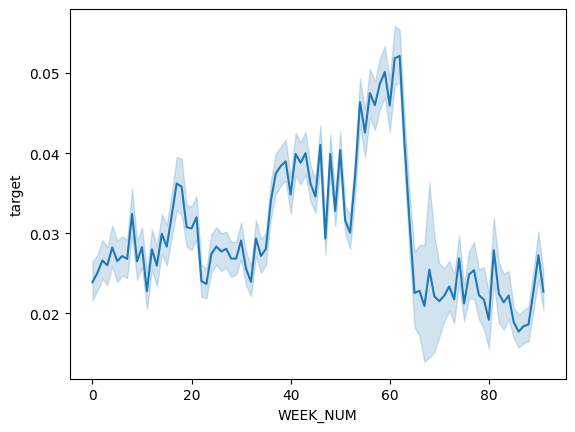

In [27]:
sns.lineplot(
    data=df_train,
    x="WEEK_NUM",
    y="target",
)
plt.show()

In [28]:
X = df_train.drop(columns=["target", "case_id","WEEK_NUM"])
y = df_train["target"]
weeks = df_train["WEEK_NUM"]

In [29]:
from sklearn.model_selection import KFold

# Assuming X, y, and weeks are your features, labels, and grouping information
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Get the first split
idx_train, idx_valid = next(cv.split(X, y, groups=weeks))

X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

# Now, you can use X_train, y_train for training and X_valid, y_valid for validation
# Your model training and evaluation code can go here


In [30]:
import xgboost as xgb
params = {
    "device":"cuda",
    "objective":'binary:logistic',
    "tree_method":"hist",
    "enable_categorical":True,
    "eval_metric":'auc',
    "subsample":1,
    "colsample_bytree":1,
    "min_child_weight":1,
    "max_depth":20,
    #gamma=0.7,
    #reg_alpha=0.7,
    "n_estimators":120,
    "random_state":42,
}
xgb_model = xgb.XGBClassifier(**params)

xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=100,
        verbose=True,
    )

y_pred_valid = xgb_model.predict_proba(X_valid)[:, 1]
auc_score = roc_auc_score(y_valid, y_pred_valid)

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [03:41:47] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.69813
[1]	validation_0-auc:0.72356
[2]	validation_0-auc:0.73983
[3]	validation_0-auc:0.74862
[4]	validation_0-auc:0.75539
[5]	validation_0-auc:0.75783
[6]	validation_0-auc:0.76121
[7]	validation_0-auc:0.76576
[8]	validation_0-auc:0.76790
[9]	validation_0-auc:0.77057
[10]	validation_0-auc:0.77295
[11]	validation_0-auc:0.77503
[12]	validation_0-auc:0.77809
[13]	validation_0-auc:0.78014
[14]	validation_0-auc:0.78172
[15]	validation_0-auc:0.78293
[16]	validation_0-auc:0.78435
[17]	validation_0-auc:0.78532
[18]	validation_0-auc:0.78564
[19]	validation_0-auc:0.78641
[20]	validation_0-auc:0.78680
[21]	validation_0-auc:0.78750
[22]	validation_0-auc:0.78784
[23]	validation_0-auc:0.78796
[24]	validation_0-auc:0.78884
[25]	validation_0-auc:0.78919
[26]	validation_0-auc:0.78917
[27]	validation_0-auc:0.78964
[28]	validation_0-auc:0.78971
[29]	validation_0-auc:0.79035
[30]	validation_0-auc:0.79118
[31]	validation_0-auc:0.79135
[32]	validation_0-auc:0.79179
[33]	validation_0-au

In [31]:
auc_score

0.8000815137642198

In [32]:
X_test = df_test.drop(columns=["WEEK_NUM"])
X_test = X_test.set_index("case_id")

xgb_pred = pd.Series(xgb_model.predict_proba(X_test)[:, 1], index=X_test.index)

In [33]:
xgb_pred

case_id
57543    0.001051
57549    0.003575
57551    0.004209
57552    0.010011
57569    0.000469
57630    0.014755
57631    0.013017
57632    0.017633
57633    0.003404
57634    0.023823
dtype: float32

In [34]:
df_subm = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

df_subm["score"] = (xgb_pred)*0.5

In [35]:
df_subm

,score
case_id,
57543,0.000525
57549,0.001788
57551,0.002104
57552,0.005005
57569,0.000235
57630,0.007378
57631,0.006509
57632,0.008817
57633,0.001702


In [36]:
print("Check null: ", df_subm["score"].isnull().any())

Check null:  False


In [37]:
df_subm.to_csv("submission.csv")